In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=8)
df.to_pickle('/tmp/df_horizon8_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.625000   
                          BTC     10564.250000  10630.000000  10525.500000   
                          ETH       225.930000    226.440000    225.510000   
                          XRP         0.327975      0.328400      0.327000   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.335000   
...                                        ...           ...           ...   
2022-10-28 04:00:00+00:00 ETH      1508.000000   1510.500000   1505.700000   
                          LINK        6.897000      6.920000      6.885000   
                          MATIC       0.902400      0.910000      0.900900   
                          SOL        30.685000     30.727500     30.590000   
                          XRP         0.463225      0.464975      0.462775   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-10-28 04:00:00+00:00 ETH      1508.500000  4.329494e+07   
                          LINK        6.903500  6.994673e+05   
                          MATIC       0.907600  1.867808e+06   
                          SOL        30.632500  4.769334e+06   
                          XRP         0.463450  1.195240e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00  0.026612  
                          BTC    2019-07-20 13:00:00+00:00  0.034090  
                          ETH    2019-07-20 13:00:00+00:00  0.030901  
                          XRP    2019-07-20 13:00:00+00:00  0.037908  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00  0.026836  
...                                                    ...       ...  
2022-10-28 04:00:00+00:00 ETH    2022-10-28 05:00:00+00:00       NaN  
                          LINK   2022-10-28 05:00:00+00:00       NaN  
                          MATIC  2022-10-28 05:00:00+00:00       NaN  
                          SOL    2022-10-28 05:00:00+00:00       NaN  
                          XRP    2022-10-28 05:00:00+00:00       NaN  

[259078 rows x 7 columns]

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-10-28 06:16:08.717307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 06:16:08.850491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 06:16:08.850537: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 06:16:08.877779: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 06:16:09.448801: W tensorflow/stream_executor/platform/de

In [4]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [5]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [6]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [7]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [8]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [9]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble
        self.horizon = 8

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        # df['position_beta'] = df['position'] * df['beta']
        # df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        # df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (199332, 39)


2022-10-28 06:16:15.940730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 06:16:15.940791: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 06:16:15.940821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (65854e213ab4): /proc/driver/nvidia/version does not exist
2022-10-28 06:16:15.941018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
35/35 - 2s - loss: 1.1106 - mse: 1.0030 - weighted_mse: 0.9878 - cosine_similarity: 0.1067 - val_loss: 0.7078 - val_mse: 1.0016 - val_weighted_mse: 0.9970 - val_cosine_similarity: 0.0623 - 2s/epoch - 63ms/step
Epoch 2/1000
35/35 - 1s - loss: 1.0999 - mse: 1.0016 - weighted_mse: 0.9783 - cosine_similarity: 0.1292 - val_loss: 0.7071 - val_mse: 1.0019 - val_weighted_mse: 0.9960 - val_cosine_similarity: 0.0546 - 698ms/epoch - 20ms/step
Epoch 3/1000
35/35 - 1s - loss: 1.0924 - mse: 1.0004 - weighted_mse: 0.9716 - cosine_similarity: 0.1330 - val_loss: 0.7055 - val_mse: 1.0011 - val_weighted_mse: 0.9938 - val_cosine_similarity: 0.0542 - 706ms/epoch - 20ms/step
Epoch 4/1000
35/35 - 1s - loss: 1.0875 - mse: 0.9989 - weighted_mse: 0.9672 - cosine_similarity: 0.1476 - val_loss: 0.7056 - val_mse: 1.0024 - val_weighted_mse: 0.9939 - val_cosine_similarity: 0.0636 - 732ms/epoch - 21ms/step
Epoch 5/1000
35/35 - 1s - loss: 1.0840 - mse: 0.9984 - weighted_mse: 0.9641 - cosine_similarity: 0.

INFO:tensorflow:Assets written to: /tmp/tmpdkdm_yh5/assets


INFO:tensorflow:Assets written to: /tmp/tmpdkdm_yh5/assets
2022-10-28 06:23:36.422710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:36.422796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:36.423663: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdkdm_yh5
2022-10-28 06:23:36.426121: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:36.426164: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdkdm_yh5
2022-10-28 06:23:36.434805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-28 06:23:36.436850: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:36.502450: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpang0lnqc/assets


INFO:tensorflow:Assets written to: /tmp/tmpang0lnqc/assets
2022-10-28 06:23:38.422426: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:38.422508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:38.422708: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpang0lnqc
2022-10-28 06:23:38.424936: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:38.424980: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpang0lnqc
2022-10-28 06:23:38.433750: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:38.496544: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpang0lnqc
2022-10-28 06:23:38.513211: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe2axzgvf/assets


INFO:tensorflow:Assets written to: /tmp/tmpe2axzgvf/assets
2022-10-28 06:23:40.324850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:40.324927: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:40.325156: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe2axzgvf
2022-10-28 06:23:40.327175: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:40.327216: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe2axzgvf
2022-10-28 06:23:40.335228: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:40.393014: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe2axzgvf
2022-10-28 06:23:40.408165: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvy34klq3/assets


INFO:tensorflow:Assets written to: /tmp/tmpvy34klq3/assets
2022-10-28 06:23:42.597976: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:42.598047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:42.598224: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvy34klq3
2022-10-28 06:23:42.600326: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:42.600362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvy34klq3
2022-10-28 06:23:42.606654: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:42.661818: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvy34klq3
2022-10-28 06:23:42.677222: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc0qjn5x6/assets


INFO:tensorflow:Assets written to: /tmp/tmpc0qjn5x6/assets
2022-10-28 06:23:44.239722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:44.239788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:44.239958: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc0qjn5x6
2022-10-28 06:23:44.241759: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:44.241793: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc0qjn5x6
2022-10-28 06:23:44.247693: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:44.307065: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc0qjn5x6
2022-10-28 06:23:44.321159: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4pd5wefr/assets


INFO:tensorflow:Assets written to: /tmp/tmp4pd5wefr/assets
2022-10-28 06:23:45.769175: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:45.769253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:45.769434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4pd5wefr
2022-10-28 06:23:45.771132: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:45.771167: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4pd5wefr
2022-10-28 06:23:45.776789: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:45.824651: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4pd5wefr
2022-10-28 06:23:45.837395: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpua9eb4lm/assets


INFO:tensorflow:Assets written to: /tmp/tmpua9eb4lm/assets
2022-10-28 06:23:47.268771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:47.268833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:47.269001: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpua9eb4lm
2022-10-28 06:23:47.270624: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:47.270657: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpua9eb4lm
2022-10-28 06:23:47.275914: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:47.323200: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpua9eb4lm
2022-10-28 06:23:47.335333: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5piv2hqb/assets


INFO:tensorflow:Assets written to: /tmp/tmp5piv2hqb/assets
2022-10-28 06:23:48.698611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:48.698683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:48.698847: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5piv2hqb
2022-10-28 06:23:48.700468: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:48.700500: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5piv2hqb
2022-10-28 06:23:48.705667: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:48.751047: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5piv2hqb
2022-10-28 06:23:48.763033: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp36wdmtra/assets


INFO:tensorflow:Assets written to: /tmp/tmp36wdmtra/assets
2022-10-28 06:23:50.104803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:50.104863: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:50.105019: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36wdmtra
2022-10-28 06:23:50.106586: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:50.106614: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp36wdmtra
2022-10-28 06:23:50.111810: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:50.157579: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp36wdmtra
2022-10-28 06:23:50.169588: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp28l6sa2v/assets


INFO:tensorflow:Assets written to: /tmp/tmp28l6sa2v/assets
2022-10-28 06:23:51.473631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:23:51.473691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:23:51.473843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp28l6sa2v
2022-10-28 06:23:51.475389: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:23:51.475416: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp28l6sa2v
2022-10-28 06:23:51.480380: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:23:51.524456: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp28l6sa2v
2022-10-28 06:23:51.536222: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

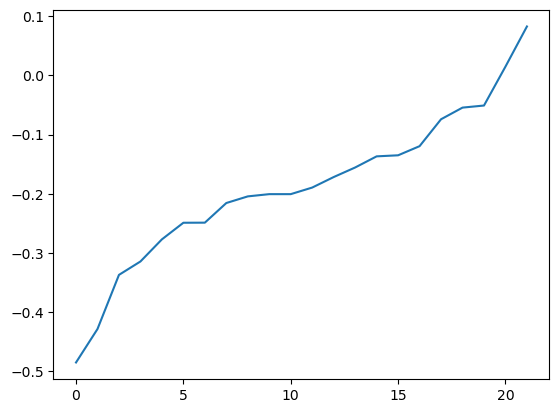

fit df.shape (185261, 39)
Epoch 1/1000
32/32 - 2s - loss: 1.1152 - mse: 1.0020 - weighted_mse: 0.9912 - cosine_similarity: 0.0748 - val_loss: 0.7058 - val_mse: 1.0004 - val_weighted_mse: 0.9964 - val_cosine_similarity: 0.0102 - 2s/epoch - 62ms/step
Epoch 2/1000
32/32 - 1s - loss: 1.1077 - mse: 1.0021 - weighted_mse: 0.9846 - cosine_similarity: 0.1009 - val_loss: 0.7055 - val_mse: 1.0012 - val_weighted_mse: 0.9960 - val_cosine_similarity: 0.0333 - 560ms/epoch - 17ms/step
Epoch 3/1000
32/32 - 1s - loss: 1.1020 - mse: 1.0018 - weighted_mse: 0.9795 - cosine_similarity: 0.1159 - val_loss: 0.7054 - val_mse: 1.0017 - val_weighted_mse: 0.9958 - val_cosine_similarity: 0.0465 - 568ms/epoch - 18ms/step
Epoch 4/1000
32/32 - 1s - loss: 1.0969 - mse: 1.0016 - weighted_mse: 0.9750 - cosine_similarity: 0.1280 - val_loss: 0.7047 - val_mse: 1.0008 - val_weighted_mse: 0.9949 - val_cosine_similarity: 0.0510 - 552ms/epoch - 17ms/step
Epoch 5/1000
32/32 - 1s - loss: 1.0934 - mse: 1.0016 - weighted_mse: 0.97

INFO:tensorflow:Assets written to: /tmp/tmp4oalkumd/assets


INFO:tensorflow:Assets written to: /tmp/tmp4oalkumd/assets
2022-10-28 06:33:51.562248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:51.562331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:51.562528: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4oalkumd
2022-10-28 06:33:51.564651: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:51.564691: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4oalkumd
2022-10-28 06:33:51.571318: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:51.630035: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4oalkumd
2022-10-28 06:33:51.645322: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc0gg185m/assets


INFO:tensorflow:Assets written to: /tmp/tmpc0gg185m/assets
2022-10-28 06:33:53.351093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:53.351165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:53.351351: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc0gg185m
2022-10-28 06:33:53.353311: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:53.353349: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc0gg185m
2022-10-28 06:33:53.359648: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:53.418149: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc0gg185m
2022-10-28 06:33:53.433169: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3pw00czh/assets


INFO:tensorflow:Assets written to: /tmp/tmp3pw00czh/assets
2022-10-28 06:33:55.061655: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:55.061724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:55.061961: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3pw00czh
2022-10-28 06:33:55.063774: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:55.063809: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3pw00czh
2022-10-28 06:33:55.069925: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:55.123395: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3pw00czh
2022-10-28 06:33:55.137588: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp37jkib58/assets


INFO:tensorflow:Assets written to: /tmp/tmp37jkib58/assets
2022-10-28 06:33:56.703538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:56.703612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:56.703787: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp37jkib58
2022-10-28 06:33:56.705779: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:56.705817: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp37jkib58
2022-10-28 06:33:56.711854: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:56.764550: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp37jkib58
2022-10-28 06:33:56.778328: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeh86zasq/assets


INFO:tensorflow:Assets written to: /tmp/tmpeh86zasq/assets
2022-10-28 06:33:58.245875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:58.245938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:58.246098: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeh86zasq
2022-10-28 06:33:58.247774: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:58.247802: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeh86zasq
2022-10-28 06:33:58.253434: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:58.301534: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeh86zasq
2022-10-28 06:33:58.313950: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxytuzg8b/assets


INFO:tensorflow:Assets written to: /tmp/tmpxytuzg8b/assets
2022-10-28 06:33:59.745078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:33:59.745141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:33:59.745299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxytuzg8b
2022-10-28 06:33:59.746955: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:33:59.746986: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxytuzg8b
2022-10-28 06:33:59.752637: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:33:59.799820: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxytuzg8b
2022-10-28 06:33:59.811986: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphb8v1hhh/assets


INFO:tensorflow:Assets written to: /tmp/tmphb8v1hhh/assets
2022-10-28 06:34:01.194389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:34:01.194457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:34:01.194618: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphb8v1hhh
2022-10-28 06:34:01.196319: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:34:01.196351: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphb8v1hhh
2022-10-28 06:34:01.203343: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:34:01.249279: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphb8v1hhh
2022-10-28 06:34:01.261481: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7v8rfmwv/assets


INFO:tensorflow:Assets written to: /tmp/tmp7v8rfmwv/assets
2022-10-28 06:34:02.623807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:34:02.623859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:34:02.624021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7v8rfmwv
2022-10-28 06:34:02.625598: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:34:02.625629: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7v8rfmwv
2022-10-28 06:34:02.632049: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:34:02.676070: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7v8rfmwv
2022-10-28 06:34:02.687834: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp20rgewne/assets


INFO:tensorflow:Assets written to: /tmp/tmp20rgewne/assets
2022-10-28 06:34:04.000303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:34:04.000364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:34:04.000515: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp20rgewne
2022-10-28 06:34:04.002184: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:34:04.002215: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp20rgewne
2022-10-28 06:34:04.008634: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:34:04.053326: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp20rgewne
2022-10-28 06:34:04.064787: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3al9oe5p/assets


INFO:tensorflow:Assets written to: /tmp/tmp3al9oe5p/assets
2022-10-28 06:34:06.420922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:34:06.420983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:34:06.421135: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3al9oe5p
2022-10-28 06:34:06.422850: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:34:06.422938: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3al9oe5p
2022-10-28 06:34:06.428635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:34:06.476977: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3al9oe5p
2022-10-28 06:34:06.489750: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

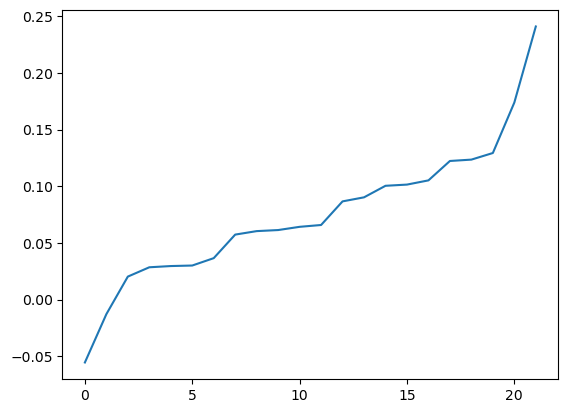

fit df.shape (178193, 39)
Epoch 1/1000
31/31 - 2s - loss: 1.0586 - mse: 0.9997 - weighted_mse: 0.9943 - cosine_similarity: 0.0654 - val_loss: 0.8468 - val_mse: 1.0002 - val_weighted_mse: 0.9972 - val_cosine_similarity: 0.0460 - 2s/epoch - 75ms/step
Epoch 2/1000
31/31 - 1s - loss: 1.0513 - mse: 0.9992 - weighted_mse: 0.9875 - cosine_similarity: 0.1018 - val_loss: 0.8458 - val_mse: 1.0013 - val_weighted_mse: 0.9960 - val_cosine_similarity: 0.0532 - 535ms/epoch - 17ms/step
Epoch 3/1000
31/31 - 1s - loss: 1.0457 - mse: 0.9990 - weighted_mse: 0.9822 - cosine_similarity: 0.1182 - val_loss: 0.8456 - val_mse: 1.0025 - val_weighted_mse: 0.9958 - val_cosine_similarity: 0.0593 - 550ms/epoch - 18ms/step
Epoch 4/1000
31/31 - 1s - loss: 1.0409 - mse: 0.9992 - weighted_mse: 0.9777 - cosine_similarity: 0.1275 - val_loss: 0.8437 - val_mse: 1.0010 - val_weighted_mse: 0.9935 - val_cosine_similarity: 0.0545 - 545ms/epoch - 18ms/step
Epoch 5/1000
31/31 - 1s - loss: 1.0370 - mse: 0.9983 - weighted_mse: 0.97

INFO:tensorflow:Assets written to: /tmp/tmpihwnk1ad/assets


INFO:tensorflow:Assets written to: /tmp/tmpihwnk1ad/assets
2022-10-28 06:42:21.248360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:21.248436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:21.248623: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpihwnk1ad
2022-10-28 06:42:21.250610: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:21.250649: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpihwnk1ad
2022-10-28 06:42:21.257044: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:21.315006: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpihwnk1ad
2022-10-28 06:42:21.329966: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp36ycxeyl/assets


INFO:tensorflow:Assets written to: /tmp/tmp36ycxeyl/assets
2022-10-28 06:42:22.974990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:22.975070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:22.975314: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36ycxeyl
2022-10-28 06:42:22.977170: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:22.977276: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp36ycxeyl
2022-10-28 06:42:22.983567: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:23.038047: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp36ycxeyl
2022-10-28 06:42:23.051777: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc1lqzg_8/assets


INFO:tensorflow:Assets written to: /tmp/tmpc1lqzg_8/assets
2022-10-28 06:42:24.614739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:24.614806: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:24.614977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc1lqzg_8
2022-10-28 06:42:24.616771: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:24.616806: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc1lqzg_8
2022-10-28 06:42:24.622641: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:24.674930: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc1lqzg_8
2022-10-28 06:42:24.689112: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwzpu49_s/assets


INFO:tensorflow:Assets written to: /tmp/tmpwzpu49_s/assets
2022-10-28 06:42:26.149015: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:26.149076: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:26.149283: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwzpu49_s
2022-10-28 06:42:26.150911: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:26.150944: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwzpu49_s
2022-10-28 06:42:26.156422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:26.207366: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwzpu49_s
2022-10-28 06:42:26.219812: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgiurkk23/assets


INFO:tensorflow:Assets written to: /tmp/tmpgiurkk23/assets
2022-10-28 06:42:27.631358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:27.631419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:27.631577: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgiurkk23
2022-10-28 06:42:27.633158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:27.633190: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgiurkk23
2022-10-28 06:42:27.638477: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:27.684834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgiurkk23
2022-10-28 06:42:27.697457: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfd1uuck0/assets


INFO:tensorflow:Assets written to: /tmp/tmpfd1uuck0/assets
2022-10-28 06:42:29.055830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:29.055893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:29.056085: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfd1uuck0
2022-10-28 06:42:29.057628: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:29.057660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfd1uuck0
2022-10-28 06:42:29.062804: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:29.107729: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfd1uuck0
2022-10-28 06:42:29.119623: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbheip0y4/assets


INFO:tensorflow:Assets written to: /tmp/tmpbheip0y4/assets
2022-10-28 06:42:30.439058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:30.439118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:30.439315: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbheip0y4
2022-10-28 06:42:30.440833: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:30.440864: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbheip0y4
2022-10-28 06:42:30.445929: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:30.490269: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbheip0y4
2022-10-28 06:42:30.501733: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6w9b76__/assets


INFO:tensorflow:Assets written to: /tmp/tmp6w9b76__/assets
2022-10-28 06:42:31.786376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:31.786439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:31.786594: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6w9b76__
2022-10-28 06:42:31.788102: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:31.788133: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6w9b76__
2022-10-28 06:42:31.793141: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:31.837715: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6w9b76__
2022-10-28 06:42:31.849269: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg4kfcywg/assets


INFO:tensorflow:Assets written to: /tmp/tmpg4kfcywg/assets
2022-10-28 06:42:33.149863: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:33.149923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:33.150127: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg4kfcywg
2022-10-28 06:42:33.151740: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:33.151771: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg4kfcywg
2022-10-28 06:42:33.158470: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:33.202887: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg4kfcywg
2022-10-28 06:42:33.214850: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptv57pl_f/assets


INFO:tensorflow:Assets written to: /tmp/tmptv57pl_f/assets
2022-10-28 06:42:34.537289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:42:34.537346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:42:34.537498: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptv57pl_f
2022-10-28 06:42:34.539098: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:42:34.539130: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptv57pl_f
2022-10-28 06:42:34.545541: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:42:34.590674: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptv57pl_f
2022-10-28 06:42:34.602315: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

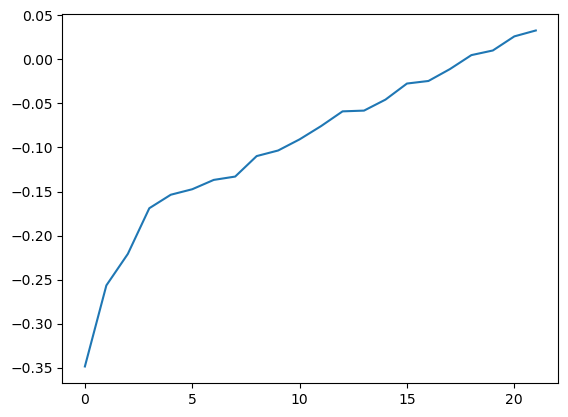

fit df.shape (178193, 39)
Epoch 1/1000
31/31 - 2s - loss: 1.1099 - mse: 1.0016 - weighted_mse: 0.9874 - cosine_similarity: 0.1055 - val_loss: 0.7077 - val_mse: 1.0016 - val_weighted_mse: 0.9960 - val_cosine_similarity: 0.0884 - 2s/epoch - 66ms/step
Epoch 2/1000
31/31 - 1s - loss: 1.0988 - mse: 1.0013 - weighted_mse: 0.9775 - cosine_similarity: 0.1302 - val_loss: 0.7061 - val_mse: 1.0017 - val_weighted_mse: 0.9938 - val_cosine_similarity: 0.0827 - 569ms/epoch - 18ms/step
Epoch 3/1000
31/31 - 1s - loss: 1.0907 - mse: 1.0000 - weighted_mse: 0.9703 - cosine_similarity: 0.1450 - val_loss: 0.7040 - val_mse: 1.0002 - val_weighted_mse: 0.9909 - val_cosine_similarity: 0.0663 - 549ms/epoch - 18ms/step
Epoch 4/1000
31/31 - 1s - loss: 1.0849 - mse: 0.9993 - weighted_mse: 0.9652 - cosine_similarity: 0.1521 - val_loss: 0.7035 - val_mse: 1.0011 - val_weighted_mse: 0.9900 - val_cosine_similarity: 0.0695 - 538ms/epoch - 17ms/step
Epoch 5/1000
31/31 - 1s - loss: 1.0806 - mse: 0.9994 - weighted_mse: 0.96

INFO:tensorflow:Assets written to: /tmp/tmpdryyi9dw/assets


INFO:tensorflow:Assets written to: /tmp/tmpdryyi9dw/assets
2022-10-28 06:50:27.314882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:27.314963: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:27.315149: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdryyi9dw
2022-10-28 06:50:27.317087: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:27.317124: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdryyi9dw
2022-10-28 06:50:27.323693: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:27.379247: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdryyi9dw
2022-10-28 06:50:27.393829: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgm42e4tm/assets


INFO:tensorflow:Assets written to: /tmp/tmpgm42e4tm/assets
2022-10-28 06:50:28.976929: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:28.976997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:28.977174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgm42e4tm
2022-10-28 06:50:28.979063: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:28.979099: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgm42e4tm
2022-10-28 06:50:28.985573: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:29.040212: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgm42e4tm
2022-10-28 06:50:29.054397: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph0gn8xnv/assets


INFO:tensorflow:Assets written to: /tmp/tmph0gn8xnv/assets
2022-10-28 06:50:31.364350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:31.364417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:31.364630: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph0gn8xnv
2022-10-28 06:50:31.366669: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:31.366704: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph0gn8xnv
2022-10-28 06:50:31.373248: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:31.425480: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph0gn8xnv
2022-10-28 06:50:31.439289: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfhci0b_s/assets


INFO:tensorflow:Assets written to: /tmp/tmpfhci0b_s/assets
2022-10-28 06:50:32.892745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:32.892808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:32.892968: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfhci0b_s
2022-10-28 06:50:32.894669: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:32.894701: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfhci0b_s
2022-10-28 06:50:32.900063: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:32.947072: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfhci0b_s
2022-10-28 06:50:32.959589: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg_sozrb9/assets


INFO:tensorflow:Assets written to: /tmp/tmpg_sozrb9/assets
2022-10-28 06:50:34.329866: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:34.329926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:34.330080: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg_sozrb9
2022-10-28 06:50:34.331678: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:34.331711: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg_sozrb9
2022-10-28 06:50:34.336898: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:34.387264: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg_sozrb9
2022-10-28 06:50:34.400790: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsitlyn1c/assets


INFO:tensorflow:Assets written to: /tmp/tmpsitlyn1c/assets
2022-10-28 06:50:35.738550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:35.738654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:35.738810: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsitlyn1c
2022-10-28 06:50:35.740364: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:35.740395: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsitlyn1c
2022-10-28 06:50:35.745542: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:35.790525: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsitlyn1c
2022-10-28 06:50:35.802066: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdatjap9i/assets


INFO:tensorflow:Assets written to: /tmp/tmpdatjap9i/assets
2022-10-28 06:50:37.092788: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:37.092845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:37.092994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdatjap9i
2022-10-28 06:50:37.094501: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:37.094530: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdatjap9i
2022-10-28 06:50:37.099580: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:37.143575: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdatjap9i
2022-10-28 06:50:37.155226: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0ngj27d2/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ngj27d2/assets
2022-10-28 06:50:38.488146: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:38.488205: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:38.488358: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0ngj27d2
2022-10-28 06:50:38.489916: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:38.489948: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0ngj27d2
2022-10-28 06:50:38.494981: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:38.540058: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0ngj27d2
2022-10-28 06:50:38.551981: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm43b6ui4/assets


INFO:tensorflow:Assets written to: /tmp/tmpm43b6ui4/assets
2022-10-28 06:50:39.869249: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:39.869309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:39.869507: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm43b6ui4
2022-10-28 06:50:39.871004: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:39.871034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm43b6ui4
2022-10-28 06:50:39.876018: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:39.920089: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm43b6ui4
2022-10-28 06:50:39.931771: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsgr6zhci/assets


INFO:tensorflow:Assets written to: /tmp/tmpsgr6zhci/assets
2022-10-28 06:50:41.234555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 06:50:41.234616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 06:50:41.234814: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsgr6zhci
2022-10-28 06:50:41.236331: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 06:50:41.236361: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsgr6zhci
2022-10-28 06:50:41.241362: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 06:50:41.285327: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsgr6zhci
2022-10-28 06:50:41.296725: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

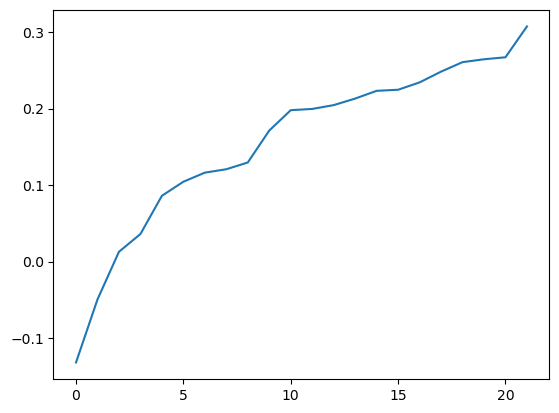

fit df.shape (178499, 39)
Epoch 1/1000
31/31 - 2s - loss: 1.0365 - mse: 1.0017 - weighted_mse: 0.9875 - cosine_similarity: 0.1065 - val_loss: 0.8814 - val_mse: 1.0021 - val_weighted_mse: 0.9967 - val_cosine_similarity: 0.0488 - 2s/epoch - 69ms/step
Epoch 2/1000
31/31 - 1s - loss: 1.0264 - mse: 1.0013 - weighted_mse: 0.9779 - cosine_similarity: 0.1349 - val_loss: 0.8803 - val_mse: 1.0029 - val_weighted_mse: 0.9955 - val_cosine_similarity: 0.0542 - 550ms/epoch - 18ms/step
Epoch 3/1000
31/31 - 1s - loss: 1.0186 - mse: 0.9999 - weighted_mse: 0.9705 - cosine_similarity: 0.1429 - val_loss: 0.8795 - val_mse: 1.0023 - val_weighted_mse: 0.9946 - val_cosine_similarity: 0.0673 - 549ms/epoch - 18ms/step
Epoch 4/1000
31/31 - 1s - loss: 1.0129 - mse: 0.9996 - weighted_mse: 0.9650 - cosine_similarity: 0.1504 - val_loss: 0.8797 - val_mse: 1.0017 - val_weighted_mse: 0.9948 - val_cosine_similarity: 0.0581 - 551ms/epoch - 18ms/step
Epoch 5/1000
31/31 - 1s - loss: 1.0088 - mse: 0.9989 - weighted_mse: 0.96

INFO:tensorflow:Assets written to: /tmp/tmpvh91kqmb/assets


INFO:tensorflow:Assets written to: /tmp/tmpvh91kqmb/assets
2022-10-28 07:03:45.360267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:45.360337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:45.360565: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvh91kqmb
2022-10-28 07:03:45.362455: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:45.362490: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvh91kqmb
2022-10-28 07:03:45.368527: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:45.422391: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvh91kqmb
2022-10-28 07:03:45.436734: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwbnpc42d/assets


INFO:tensorflow:Assets written to: /tmp/tmpwbnpc42d/assets
2022-10-28 07:03:47.019794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:47.019866: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:47.020098: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwbnpc42d
2022-10-28 07:03:47.022005: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:47.022106: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwbnpc42d
2022-10-28 07:03:47.028656: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:47.080697: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwbnpc42d
2022-10-28 07:03:47.094754: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpif7dgm_a/assets


INFO:tensorflow:Assets written to: /tmp/tmpif7dgm_a/assets
2022-10-28 07:03:48.558505: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:48.558567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:48.558732: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpif7dgm_a
2022-10-28 07:03:48.560431: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:48.560464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpif7dgm_a
2022-10-28 07:03:48.566366: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:48.614368: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpif7dgm_a
2022-10-28 07:03:48.627198: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpffx132mi/assets


INFO:tensorflow:Assets written to: /tmp/tmpffx132mi/assets
2022-10-28 07:03:50.040308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:50.040372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:50.040533: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpffx132mi
2022-10-28 07:03:50.042186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:50.042218: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpffx132mi
2022-10-28 07:03:50.047499: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:50.094344: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpffx132mi
2022-10-28 07:03:50.106704: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsth1rfrq/assets


INFO:tensorflow:Assets written to: /tmp/tmpsth1rfrq/assets
2022-10-28 07:03:51.487126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:51.487190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:51.487353: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsth1rfrq
2022-10-28 07:03:51.488922: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:51.488953: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsth1rfrq
2022-10-28 07:03:51.494573: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:51.541264: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsth1rfrq
2022-10-28 07:03:51.553252: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoek7ur_0/assets


INFO:tensorflow:Assets written to: /tmp/tmpoek7ur_0/assets
2022-10-28 07:03:52.914474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:52.914546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:52.914709: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoek7ur_0
2022-10-28 07:03:52.916304: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:52.916338: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoek7ur_0
2022-10-28 07:03:52.921518: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:52.966991: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoek7ur_0
2022-10-28 07:03:52.979250: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1xg2wb2r/assets


INFO:tensorflow:Assets written to: /tmp/tmp1xg2wb2r/assets
2022-10-28 07:03:54.332915: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:54.332980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:54.333196: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1xg2wb2r
2022-10-28 07:03:54.334754: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:54.334785: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1xg2wb2r
2022-10-28 07:03:54.340087: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:54.385702: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1xg2wb2r
2022-10-28 07:03:54.398111: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1gfwgpdj/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gfwgpdj/assets
2022-10-28 07:03:55.760156: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:55.760215: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:55.760366: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1gfwgpdj
2022-10-28 07:03:55.761931: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:55.761960: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1gfwgpdj
2022-10-28 07:03:55.767249: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:55.811112: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1gfwgpdj
2022-10-28 07:03:55.822601: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp206qarey/assets


INFO:tensorflow:Assets written to: /tmp/tmp206qarey/assets
2022-10-28 07:03:57.133852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:57.133911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:57.134104: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp206qarey
2022-10-28 07:03:57.135620: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:57.135650: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp206qarey
2022-10-28 07:03:57.140707: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:57.184313: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp206qarey
2022-10-28 07:03:57.195718: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3tjt7jsu/assets


INFO:tensorflow:Assets written to: /tmp/tmp3tjt7jsu/assets
2022-10-28 07:03:58.492915: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 07:03:58.492975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 07:03:58.493163: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3tjt7jsu
2022-10-28 07:03:58.494658: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 07:03:58.494687: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3tjt7jsu
2022-10-28 07:03:58.499710: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 07:03:58.543453: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3tjt7jsu
2022-10-28 07:03:58.555036: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

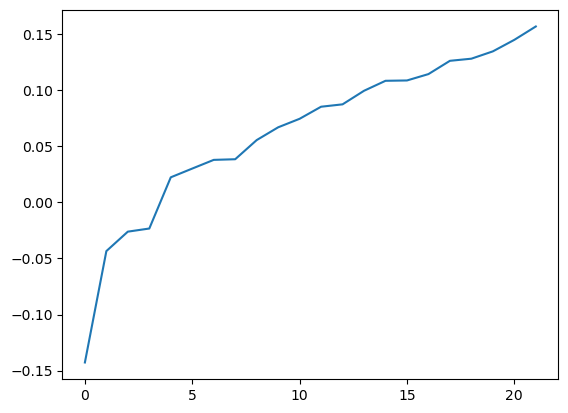

return without cost statistics
mean 0.0025550902339449527
std 0.025398819769611596
sharpe 0.10059877809763385
double sharpe 1.2609310508984537
max drawdown 0.5614854855714051
return with cost statistics
mean 0.0012819254843535112
std 0.02541560619043578
sharpe 0.05043851697843494
double sharpe 0.6096158498778314
max drawdown 0.5627307531369419


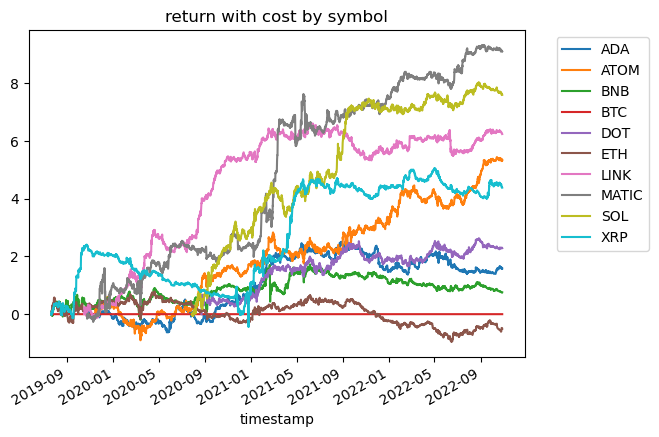

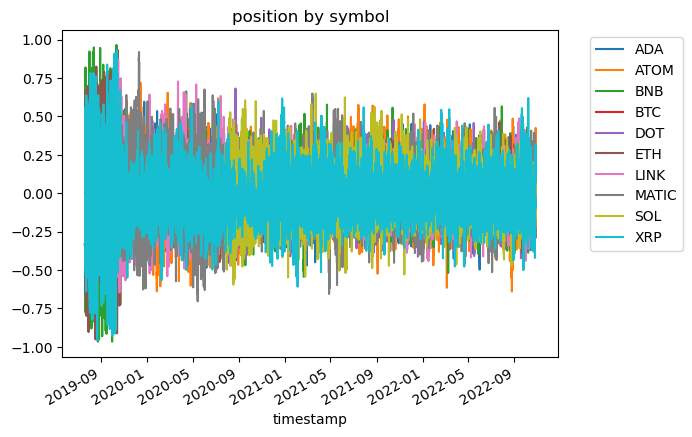

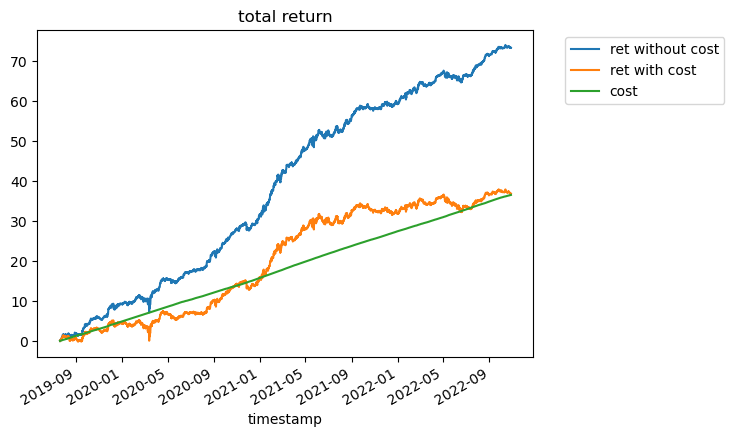

fit df.shape (230303, 39)


INFO:tensorflow:Assets written to: /tmp/tmppnxidhne/assets


INFO:tensorflow:Assets written to: /tmp/tmppnxidhne/assets
2022-10-28 08:28:39.398485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:39.398561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:39.398751: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppnxidhne
2022-10-28 08:28:39.400755: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:39.400794: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppnxidhne
2022-10-28 08:28:39.407490: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:39.464609: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppnxidhne
2022-10-28 08:28:39.480274: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvng5n5w4/assets


INFO:tensorflow:Assets written to: /tmp/tmpvng5n5w4/assets
2022-10-28 08:28:41.152190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:41.152259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:41.152433: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvng5n5w4
2022-10-28 08:28:41.154391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:41.154428: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvng5n5w4
2022-10-28 08:28:41.162156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:41.217858: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvng5n5w4
2022-10-28 08:28:41.232574: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppq9elh6s/assets


INFO:tensorflow:Assets written to: /tmp/tmppq9elh6s/assets
2022-10-28 08:28:42.829601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:42.829665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:42.829884: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppq9elh6s
2022-10-28 08:28:42.831737: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:42.831772: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppq9elh6s
2022-10-28 08:28:42.839363: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:42.892610: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppq9elh6s
2022-10-28 08:28:42.906448: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_x9rq4as/assets


INFO:tensorflow:Assets written to: /tmp/tmp_x9rq4as/assets
2022-10-28 08:28:44.417289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:44.417350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:44.417513: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_x9rq4as
2022-10-28 08:28:44.419339: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:44.419373: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_x9rq4as
2022-10-28 08:28:44.426890: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:44.476078: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_x9rq4as
2022-10-28 08:28:44.488617: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxp_7sad7/assets


INFO:tensorflow:Assets written to: /tmp/tmpxp_7sad7/assets
2022-10-28 08:28:45.944615: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:45.944676: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:45.944890: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxp_7sad7
2022-10-28 08:28:45.946623: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:45.946656: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxp_7sad7
2022-10-28 08:28:45.955174: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:46.003731: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxp_7sad7
2022-10-28 08:28:46.016147: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm06s00qo/assets


INFO:tensorflow:Assets written to: /tmp/tmpm06s00qo/assets
2022-10-28 08:28:47.428299: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:47.428358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:47.428513: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm06s00qo
2022-10-28 08:28:47.430215: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:47.430246: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm06s00qo
2022-10-28 08:28:47.437092: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:47.483026: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm06s00qo
2022-10-28 08:28:47.494763: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy9b27a8a/assets


INFO:tensorflow:Assets written to: /tmp/tmpy9b27a8a/assets
2022-10-28 08:28:48.879256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:48.879315: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:48.879467: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy9b27a8a
2022-10-28 08:28:48.881220: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:48.881255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy9b27a8a
2022-10-28 08:28:48.888198: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:48.934121: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy9b27a8a
2022-10-28 08:28:48.946088: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8basfmko/assets


INFO:tensorflow:Assets written to: /tmp/tmp8basfmko/assets
2022-10-28 08:28:51.793724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:51.793792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:51.793959: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8basfmko
2022-10-28 08:28:51.796817: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:51.796852: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8basfmko
2022-10-28 08:28:51.806732: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:51.866969: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8basfmko
2022-10-28 08:28:51.883647: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp42s8ib5o/assets


INFO:tensorflow:Assets written to: /tmp/tmp42s8ib5o/assets
2022-10-28 08:28:53.349217: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:53.349285: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:53.349443: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp42s8ib5o
2022-10-28 08:28:53.351329: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:53.351362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp42s8ib5o
2022-10-28 08:28:53.357356: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:53.405122: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp42s8ib5o
2022-10-28 08:28:53.418002: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfgg70q4d/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgg70q4d/assets
2022-10-28 08:28:54.778642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:54.778697: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:54.778897: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfgg70q4d
2022-10-28 08:28:54.780510: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:54.780536: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfgg70q4d
2022-10-28 08:28:54.786132: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:54.834472: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfgg70q4d
2022-10-28 08:28:54.847404: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxk1tsl0c/assets


INFO:tensorflow:Assets written to: /tmp/tmpxk1tsl0c/assets
2022-10-28 08:28:56.173337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:56.173397: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:56.173549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxk1tsl0c
2022-10-28 08:28:56.175125: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:56.175155: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxk1tsl0c
2022-10-28 08:28:56.180308: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:56.225517: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxk1tsl0c
2022-10-28 08:28:56.237839: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps8lj6bd7/assets


INFO:tensorflow:Assets written to: /tmp/tmps8lj6bd7/assets
2022-10-28 08:28:57.551625: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:57.551684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:57.551835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps8lj6bd7
2022-10-28 08:28:57.553389: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:57.553420: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps8lj6bd7
2022-10-28 08:28:57.558441: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:57.602472: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps8lj6bd7
2022-10-28 08:28:57.614378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphpa6l449/assets


INFO:tensorflow:Assets written to: /tmp/tmphpa6l449/assets
2022-10-28 08:28:58.947757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:28:58.947814: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:28:58.947969: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphpa6l449
2022-10-28 08:28:58.949530: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:28:58.949559: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphpa6l449
2022-10-28 08:28:58.954568: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:28:58.998663: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphpa6l449
2022-10-28 08:28:59.010330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7u4coqf3/assets


INFO:tensorflow:Assets written to: /tmp/tmp7u4coqf3/assets
2022-10-28 08:29:00.336451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:00.336508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:00.336656: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7u4coqf3
2022-10-28 08:29:00.338212: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:00.338242: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7u4coqf3
2022-10-28 08:29:00.343229: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:00.387668: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7u4coqf3
2022-10-28 08:29:00.399492: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqxc5hpav/assets


INFO:tensorflow:Assets written to: /tmp/tmpqxc5hpav/assets
2022-10-28 08:29:01.712692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:01.712752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:01.712950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqxc5hpav
2022-10-28 08:29:01.714509: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:01.714540: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqxc5hpav
2022-10-28 08:29:01.719767: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:01.764988: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqxc5hpav
2022-10-28 08:29:01.777818: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzxih1low/assets


INFO:tensorflow:Assets written to: /tmp/tmpzxih1low/assets
2022-10-28 08:29:03.071306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:03.071363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:03.071515: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzxih1low
2022-10-28 08:29:03.073016: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:03.073046: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzxih1low
2022-10-28 08:29:03.078067: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:03.121519: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzxih1low
2022-10-28 08:29:03.133808: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzqqxdp_d/assets


INFO:tensorflow:Assets written to: /tmp/tmpzqqxdp_d/assets
2022-10-28 08:29:04.452795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:04.452854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:04.453006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzqqxdp_d
2022-10-28 08:29:04.454547: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:04.454579: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzqqxdp_d
2022-10-28 08:29:04.459634: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:04.503864: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzqqxdp_d
2022-10-28 08:29:04.515887: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1_mtxecc/assets


INFO:tensorflow:Assets written to: /tmp/tmp1_mtxecc/assets
2022-10-28 08:29:05.816417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:05.816475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:05.816624: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1_mtxecc
2022-10-28 08:29:05.818163: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:05.818195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1_mtxecc
2022-10-28 08:29:05.823512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:05.867758: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1_mtxecc
2022-10-28 08:29:05.879185: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmbdydr1x/assets


INFO:tensorflow:Assets written to: /tmp/tmpmbdydr1x/assets
2022-10-28 08:29:07.219211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:07.219311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:07.219464: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmbdydr1x
2022-10-28 08:29:07.220967: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:07.220998: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmbdydr1x
2022-10-28 08:29:07.226052: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:07.270223: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmbdydr1x
2022-10-28 08:29:07.281798: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4h5sbhdq/assets


INFO:tensorflow:Assets written to: /tmp/tmp4h5sbhdq/assets
2022-10-28 08:29:08.600714: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:08.600781: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:08.600936: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4h5sbhdq
2022-10-28 08:29:08.602523: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:08.602556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4h5sbhdq
2022-10-28 08:29:08.607819: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:08.652781: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4h5sbhdq
2022-10-28 08:29:08.664822: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbd3w_8k_/assets


INFO:tensorflow:Assets written to: /tmp/tmpbd3w_8k_/assets
2022-10-28 08:29:09.887998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:09.888082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:09.888225: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbd3w_8k_
2022-10-28 08:29:09.889613: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:09.889641: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbd3w_8k_
2022-10-28 08:29:09.894331: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:09.934030: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbd3w_8k_
2022-10-28 08:29:09.944765: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxl_bhd74/assets


INFO:tensorflow:Assets written to: /tmp/tmpxl_bhd74/assets
2022-10-28 08:29:13.049905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:13.049973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:13.050140: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxl_bhd74
2022-10-28 08:29:13.053976: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:13.054012: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxl_bhd74
2022-10-28 08:29:13.072351: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:13.170939: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxl_bhd74
2022-10-28 08:29:13.200525: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw0q_qk24/assets


INFO:tensorflow:Assets written to: /tmp/tmpw0q_qk24/assets
2022-10-28 08:29:14.851694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:14.851759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:14.851924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw0q_qk24
2022-10-28 08:29:14.854534: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:14.854567: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw0q_qk24
2022-10-28 08:29:14.863481: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:14.919603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw0q_qk24
2022-10-28 08:29:14.934909: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa_67jh1f/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_67jh1f/assets
2022-10-28 08:29:16.176681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:16.176737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:16.176869: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa_67jh1f
2022-10-28 08:29:16.178369: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:16.178397: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa_67jh1f
2022-10-28 08:29:16.184056: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:16.230323: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa_67jh1f
2022-10-28 08:29:16.241201: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphporc9ye/assets


INFO:tensorflow:Assets written to: /tmp/tmphporc9ye/assets
2022-10-28 08:29:17.472425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:17.472483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:17.472639: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphporc9ye
2022-10-28 08:29:17.474259: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:17.474318: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphporc9ye
2022-10-28 08:29:17.479411: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:17.524302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphporc9ye
2022-10-28 08:29:17.536075: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdg1hhvu_/assets


INFO:tensorflow:Assets written to: /tmp/tmpdg1hhvu_/assets
2022-10-28 08:29:18.771661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:18.771715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:18.771858: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdg1hhvu_
2022-10-28 08:29:18.773306: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:18.773335: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdg1hhvu_
2022-10-28 08:29:18.778698: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:18.825456: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdg1hhvu_
2022-10-28 08:29:18.838898: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiohyk5r2/assets


INFO:tensorflow:Assets written to: /tmp/tmpiohyk5r2/assets
2022-10-28 08:29:20.016391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:20.016442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:20.016572: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiohyk5r2
2022-10-28 08:29:20.017847: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:20.017872: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiohyk5r2
2022-10-28 08:29:20.022361: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:20.061601: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiohyk5r2
2022-10-28 08:29:20.072963: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz33awiv4/assets


INFO:tensorflow:Assets written to: /tmp/tmpz33awiv4/assets
2022-10-28 08:29:21.238186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:21.238287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:21.238433: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz33awiv4
2022-10-28 08:29:21.239715: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:21.239741: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz33awiv4
2022-10-28 08:29:21.244268: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:21.283828: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz33awiv4
2022-10-28 08:29:21.295699: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdhxgaspw/assets


INFO:tensorflow:Assets written to: /tmp/tmpdhxgaspw/assets
2022-10-28 08:29:22.501042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:22.501090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:22.501215: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdhxgaspw
2022-10-28 08:29:22.502512: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:22.502537: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdhxgaspw
2022-10-28 08:29:22.506965: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:22.555721: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdhxgaspw
2022-10-28 08:29:22.567518: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_n2lqmsb/assets


INFO:tensorflow:Assets written to: /tmp/tmp_n2lqmsb/assets
2022-10-28 08:29:23.767010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:23.767062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:23.767193: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_n2lqmsb
2022-10-28 08:29:23.768481: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:23.768507: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_n2lqmsb
2022-10-28 08:29:23.772782: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:23.810969: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_n2lqmsb
2022-10-28 08:29:23.820707: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9d2vllfe/assets


INFO:tensorflow:Assets written to: /tmp/tmp9d2vllfe/assets
2022-10-28 08:29:24.993919: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:24.993973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:24.994188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9d2vllfe
2022-10-28 08:29:24.995538: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:24.995566: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9d2vllfe
2022-10-28 08:29:25.000029: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:25.039950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9d2vllfe
2022-10-28 08:29:25.050284: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj1y1cr42/assets


INFO:tensorflow:Assets written to: /tmp/tmpj1y1cr42/assets
2022-10-28 08:29:26.203911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:26.203970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:26.204143: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj1y1cr42
2022-10-28 08:29:26.205463: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:26.205490: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj1y1cr42
2022-10-28 08:29:26.210060: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:26.251271: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj1y1cr42
2022-10-28 08:29:26.261040: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqswo9ug9/assets


INFO:tensorflow:Assets written to: /tmp/tmpqswo9ug9/assets
2022-10-28 08:29:27.431446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:27.431497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:27.431626: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqswo9ug9
2022-10-28 08:29:27.432876: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:27.432901: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqswo9ug9
2022-10-28 08:29:27.437054: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:27.476147: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqswo9ug9
2022-10-28 08:29:27.486334: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5yy1hdez/assets


INFO:tensorflow:Assets written to: /tmp/tmp5yy1hdez/assets
2022-10-28 08:29:30.707243: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:30.707309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:30.707481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5yy1hdez
2022-10-28 08:29:30.710735: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:30.710771: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5yy1hdez
2022-10-28 08:29:30.724075: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:30.808810: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5yy1hdez
2022-10-28 08:29:30.832393: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6dfjl5tt/assets


INFO:tensorflow:Assets written to: /tmp/tmp6dfjl5tt/assets
2022-10-28 08:29:32.223241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:32.223304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:32.223465: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6dfjl5tt
2022-10-28 08:29:32.225541: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:32.225573: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6dfjl5tt
2022-10-28 08:29:32.232590: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:32.281122: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6dfjl5tt
2022-10-28 08:29:32.292651: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxnqscjtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpxnqscjtg/assets
2022-10-28 08:29:33.508551: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:33.508601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:33.508729: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxnqscjtg
2022-10-28 08:29:33.510061: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:33.510133: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxnqscjtg
2022-10-28 08:29:33.514949: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:33.559093: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxnqscjtg
2022-10-28 08:29:33.571209: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8stvcykx/assets


INFO:tensorflow:Assets written to: /tmp/tmp8stvcykx/assets
2022-10-28 08:29:34.777969: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:34.778023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:34.778289: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8stvcykx
2022-10-28 08:29:34.779706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:34.779732: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8stvcykx
2022-10-28 08:29:34.784767: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:34.828137: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8stvcykx
2022-10-28 08:29:34.838999: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv4gfrlrd/assets


INFO:tensorflow:Assets written to: /tmp/tmpv4gfrlrd/assets
2022-10-28 08:29:36.025981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:36.026089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:36.026328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv4gfrlrd
2022-10-28 08:29:36.027634: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:36.027660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv4gfrlrd
2022-10-28 08:29:36.032585: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:36.076332: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv4gfrlrd
2022-10-28 08:29:36.087334: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd3_nl67v/assets


INFO:tensorflow:Assets written to: /tmp/tmpd3_nl67v/assets
2022-10-28 08:29:37.287840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:37.287889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:37.288015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd3_nl67v
2022-10-28 08:29:37.289367: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:37.289393: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd3_nl67v
2022-10-28 08:29:37.293997: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:37.337982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd3_nl67v
2022-10-28 08:29:37.349643: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp4df0n3h/assets


INFO:tensorflow:Assets written to: /tmp/tmpp4df0n3h/assets
2022-10-28 08:29:38.516460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:38.516511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:38.516642: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp4df0n3h
2022-10-28 08:29:38.517936: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:38.517963: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp4df0n3h
2022-10-28 08:29:38.522453: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:38.564245: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp4df0n3h
2022-10-28 08:29:38.575033: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1dygt8qf/assets


INFO:tensorflow:Assets written to: /tmp/tmp1dygt8qf/assets
2022-10-28 08:29:39.777653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:39.777703: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:39.777835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1dygt8qf
2022-10-28 08:29:39.779231: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:39.779257: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1dygt8qf
2022-10-28 08:29:39.783749: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:39.822560: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1dygt8qf
2022-10-28 08:29:39.832954: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_8y5al3j/assets


INFO:tensorflow:Assets written to: /tmp/tmp_8y5al3j/assets
2022-10-28 08:29:41.023616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:41.023671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:41.023988: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_8y5al3j
2022-10-28 08:29:41.025241: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:41.025267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_8y5al3j
2022-10-28 08:29:41.029604: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:41.070134: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_8y5al3j
2022-10-28 08:29:41.081396: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqtpiqhqn/assets


INFO:tensorflow:Assets written to: /tmp/tmpqtpiqhqn/assets
2022-10-28 08:29:42.287514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:42.287568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:42.287702: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqtpiqhqn
2022-10-28 08:29:42.289090: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:42.289116: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqtpiqhqn
2022-10-28 08:29:42.293696: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:42.332456: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqtpiqhqn
2022-10-28 08:29:42.342757: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg6akqpl5/assets


INFO:tensorflow:Assets written to: /tmp/tmpg6akqpl5/assets
2022-10-28 08:29:45.011694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:45.011761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:45.011976: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg6akqpl5
2022-10-28 08:29:45.016380: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:45.016413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg6akqpl5
2022-10-28 08:29:45.036886: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:45.154049: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg6akqpl5
2022-10-28 08:29:45.189594: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd19vvxn6/assets


INFO:tensorflow:Assets written to: /tmp/tmpd19vvxn6/assets
2022-10-28 08:29:46.970917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:46.970980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:46.971193: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd19vvxn6
2022-10-28 08:29:46.974476: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:46.974510: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd19vvxn6
2022-10-28 08:29:46.987702: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:47.067504: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd19vvxn6
2022-10-28 08:29:47.090783: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm0rjgu5j/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0rjgu5j/assets
2022-10-28 08:29:48.511832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:48.511887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:48.512062: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm0rjgu5j
2022-10-28 08:29:48.513636: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:48.513665: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm0rjgu5j
2022-10-28 08:29:48.520006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:48.567221: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm0rjgu5j
2022-10-28 08:29:48.578465: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptdzdxay5/assets


INFO:tensorflow:Assets written to: /tmp/tmptdzdxay5/assets
2022-10-28 08:29:49.851279: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:49.851339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:49.851512: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptdzdxay5
2022-10-28 08:29:49.853347: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:49.853382: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptdzdxay5
2022-10-28 08:29:49.859687: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:49.909577: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptdzdxay5
2022-10-28 08:29:49.921757: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp85fbe9r5/assets


INFO:tensorflow:Assets written to: /tmp/tmp85fbe9r5/assets
2022-10-28 08:29:51.224452: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:51.224527: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:51.224682: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp85fbe9r5
2022-10-28 08:29:51.226312: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:51.226344: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp85fbe9r5
2022-10-28 08:29:51.231742: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:51.279472: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp85fbe9r5
2022-10-28 08:29:51.290117: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvtk1hlwx/assets


INFO:tensorflow:Assets written to: /tmp/tmpvtk1hlwx/assets
2022-10-28 08:29:52.501284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:52.501335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:52.501468: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvtk1hlwx
2022-10-28 08:29:52.502827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:52.502852: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvtk1hlwx
2022-10-28 08:29:52.507367: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:52.547117: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvtk1hlwx
2022-10-28 08:29:52.558323: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyhta4kf1/assets


INFO:tensorflow:Assets written to: /tmp/tmpyhta4kf1/assets
2022-10-28 08:29:53.752213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:53.752265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:53.752390: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyhta4kf1
2022-10-28 08:29:53.753639: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:53.753664: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyhta4kf1
2022-10-28 08:29:53.758117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:53.805623: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyhta4kf1
2022-10-28 08:29:53.816266: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqx9ukga2/assets


INFO:tensorflow:Assets written to: /tmp/tmpqx9ukga2/assets
2022-10-28 08:29:54.998554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:54.998605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:54.998806: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqx9ukga2
2022-10-28 08:29:55.000148: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:55.000173: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqx9ukga2
2022-10-28 08:29:55.004509: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:55.055282: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqx9ukga2
2022-10-28 08:29:55.067260: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu3ivg9ct/assets


INFO:tensorflow:Assets written to: /tmp/tmpu3ivg9ct/assets
2022-10-28 08:29:56.295022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:56.295105: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:56.295231: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu3ivg9ct
2022-10-28 08:29:56.296627: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:56.296652: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu3ivg9ct
2022-10-28 08:29:56.301073: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:56.339578: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu3ivg9ct
2022-10-28 08:29:56.350052: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcs5kwse1/assets


INFO:tensorflow:Assets written to: /tmp/tmpcs5kwse1/assets
2022-10-28 08:29:59.104797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:29:59.104863: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:29:59.105029: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcs5kwse1
2022-10-28 08:29:59.108478: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:29:59.108515: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcs5kwse1
2022-10-28 08:29:59.123402: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:29:59.214629: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcs5kwse1
2022-10-28 08:29:59.242088: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpteyjk4q3/assets


INFO:tensorflow:Assets written to: /tmp/tmpteyjk4q3/assets
2022-10-28 08:30:00.809385: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:00.809448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:00.809613: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpteyjk4q3
2022-10-28 08:30:00.812141: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:00.812173: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpteyjk4q3
2022-10-28 08:30:00.820560: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:00.878298: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpteyjk4q3
2022-10-28 08:30:00.891614: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqtd4bgda/assets


INFO:tensorflow:Assets written to: /tmp/tmpqtd4bgda/assets
2022-10-28 08:30:02.116491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:02.116623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:02.116965: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqtd4bgda
2022-10-28 08:30:02.118756: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:02.118785: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqtd4bgda
2022-10-28 08:30:02.125028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:02.176320: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqtd4bgda
2022-10-28 08:30:02.188797: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeeiu6hn4/assets


INFO:tensorflow:Assets written to: /tmp/tmpeeiu6hn4/assets
2022-10-28 08:30:03.457855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:03.457908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:03.458039: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeeiu6hn4
2022-10-28 08:30:03.459455: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:03.459481: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeeiu6hn4
2022-10-28 08:30:03.465560: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:03.507916: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeeiu6hn4
2022-10-28 08:30:03.518863: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxvqsp9xj/assets


INFO:tensorflow:Assets written to: /tmp/tmpxvqsp9xj/assets
2022-10-28 08:30:04.737720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:04.737771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:04.737942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxvqsp9xj
2022-10-28 08:30:04.739229: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:04.739255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxvqsp9xj
2022-10-28 08:30:04.744195: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:04.784998: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxvqsp9xj
2022-10-28 08:30:04.795204: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4ubpiz3x/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ubpiz3x/assets
2022-10-28 08:30:05.985533: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:05.985586: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:05.985755: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4ubpiz3x
2022-10-28 08:30:05.987114: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:05.987162: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4ubpiz3x
2022-10-28 08:30:05.992021: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:06.035881: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4ubpiz3x
2022-10-28 08:30:06.046110: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9q50_icg/assets


INFO:tensorflow:Assets written to: /tmp/tmp9q50_icg/assets
2022-10-28 08:30:07.269313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:07.269415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:07.269546: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9q50_icg
2022-10-28 08:30:07.270838: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:07.270864: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9q50_icg
2022-10-28 08:30:07.275602: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:07.315338: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9q50_icg
2022-10-28 08:30:07.325419: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo70dasjr/assets


INFO:tensorflow:Assets written to: /tmp/tmpo70dasjr/assets
2022-10-28 08:30:08.513377: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:08.513426: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:08.513558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo70dasjr
2022-10-28 08:30:08.514864: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:08.514891: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo70dasjr
2022-10-28 08:30:08.519446: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:08.559762: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo70dasjr
2022-10-28 08:30:08.569747: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvk7jme81/assets


INFO:tensorflow:Assets written to: /tmp/tmpvk7jme81/assets
2022-10-28 08:30:11.392284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:11.392410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:11.392607: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvk7jme81
2022-10-28 08:30:11.397880: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:11.397946: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvk7jme81
2022-10-28 08:30:11.418457: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:11.507974: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvk7jme81
2022-10-28 08:30:11.532911: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb62zam7j/assets


INFO:tensorflow:Assets written to: /tmp/tmpb62zam7j/assets
2022-10-28 08:30:13.046499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:13.046560: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:13.046727: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb62zam7j
2022-10-28 08:30:13.049226: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:13.049261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb62zam7j
2022-10-28 08:30:13.057567: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:13.112100: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb62zam7j
2022-10-28 08:30:13.125475: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp65zmm_g4/assets


INFO:tensorflow:Assets written to: /tmp/tmp65zmm_g4/assets
2022-10-28 08:30:14.374908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:14.374958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:14.375083: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp65zmm_g4
2022-10-28 08:30:14.376521: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:14.376548: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp65zmm_g4
2022-10-28 08:30:14.381803: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:14.428744: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp65zmm_g4
2022-10-28 08:30:14.440659: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuctagnst/assets


INFO:tensorflow:Assets written to: /tmp/tmpuctagnst/assets
2022-10-28 08:30:15.640227: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:15.640279: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:15.640477: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuctagnst
2022-10-28 08:30:15.641982: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:15.642006: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuctagnst
2022-10-28 08:30:15.647315: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:15.690690: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuctagnst
2022-10-28 08:30:15.702510: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpceo5z3x3/assets


INFO:tensorflow:Assets written to: /tmp/tmpceo5z3x3/assets
2022-10-28 08:30:16.882141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:16.882192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:16.882355: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpceo5z3x3
2022-10-28 08:30:16.883648: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:16.883674: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpceo5z3x3
2022-10-28 08:30:16.888294: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:16.928546: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpceo5z3x3
2022-10-28 08:30:16.943824: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpesgvzmur/assets


INFO:tensorflow:Assets written to: /tmp/tmpesgvzmur/assets
2022-10-28 08:30:18.127780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:18.127832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:18.127966: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpesgvzmur
2022-10-28 08:30:18.129506: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:18.129532: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpesgvzmur
2022-10-28 08:30:18.134297: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:18.173893: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpesgvzmur
2022-10-28 08:30:18.184310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1klkls5u/assets


INFO:tensorflow:Assets written to: /tmp/tmp1klkls5u/assets
2022-10-28 08:30:20.478499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:20.478568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:20.478740: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1klkls5u
2022-10-28 08:30:20.483361: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:20.483395: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1klkls5u
2022-10-28 08:30:20.505323: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:20.640966: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1klkls5u
2022-10-28 08:30:20.680193: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpem4z_s_7/assets


INFO:tensorflow:Assets written to: /tmp/tmpem4z_s_7/assets
2022-10-28 08:30:22.480005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:22.480069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:22.480289: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpem4z_s_7
2022-10-28 08:30:22.483544: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:22.483578: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpem4z_s_7
2022-10-28 08:30:22.496425: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:22.585965: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpem4z_s_7
2022-10-28 08:30:22.611241: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp49d3tegr/assets


INFO:tensorflow:Assets written to: /tmp/tmp49d3tegr/assets
2022-10-28 08:30:24.151259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:24.151324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:24.151523: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp49d3tegr
2022-10-28 08:30:24.153952: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:24.153986: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp49d3tegr
2022-10-28 08:30:24.162083: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:24.220142: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp49d3tegr
2022-10-28 08:30:24.238160: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_6cxf5sb/assets


INFO:tensorflow:Assets written to: /tmp/tmp_6cxf5sb/assets
2022-10-28 08:30:25.508098: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:25.508151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:25.508284: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_6cxf5sb
2022-10-28 08:30:25.509767: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:25.509795: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_6cxf5sb
2022-10-28 08:30:25.515646: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:25.561918: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_6cxf5sb
2022-10-28 08:30:25.573508: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplckrswm5/assets


INFO:tensorflow:Assets written to: /tmp/tmplckrswm5/assets
2022-10-28 08:30:26.769662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:26.769712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:26.769837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplckrswm5
2022-10-28 08:30:26.771201: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:26.771231: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplckrswm5
2022-10-28 08:30:26.776853: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:26.821853: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplckrswm5
2022-10-28 08:30:26.833600: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg53143vv/assets


INFO:tensorflow:Assets written to: /tmp/tmpg53143vv/assets
2022-10-28 08:30:28.109948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:28.109998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:28.110130: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg53143vv
2022-10-28 08:30:28.111669: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:28.111696: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg53143vv
2022-10-28 08:30:28.116719: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:28.161540: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg53143vv
2022-10-28 08:30:28.172575: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm3zoy_nx/assets


INFO:tensorflow:Assets written to: /tmp/tmpm3zoy_nx/assets
2022-10-28 08:30:29.367162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:29.367230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:29.367438: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm3zoy_nx
2022-10-28 08:30:29.369063: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:29.369096: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm3zoy_nx
2022-10-28 08:30:29.374683: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:29.419008: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm3zoy_nx
2022-10-28 08:30:29.429302: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpaknf10hd/assets


INFO:tensorflow:Assets written to: /tmp/tmpaknf10hd/assets
2022-10-28 08:30:32.061775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:32.061838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:32.062006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaknf10hd
2022-10-28 08:30:32.065227: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:32.065260: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaknf10hd
2022-10-28 08:30:32.079578: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:32.137599: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpaknf10hd
2022-10-28 08:30:32.165781: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq9ixxbyn/assets


INFO:tensorflow:Assets written to: /tmp/tmpq9ixxbyn/assets
2022-10-28 08:30:33.680381: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:33.680444: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:33.680609: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq9ixxbyn
2022-10-28 08:30:33.683343: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:33.683376: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq9ixxbyn
2022-10-28 08:30:33.692286: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:33.749743: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq9ixxbyn
2022-10-28 08:30:33.763945: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpahlyzo7e/assets


INFO:tensorflow:Assets written to: /tmp/tmpahlyzo7e/assets
2022-10-28 08:30:35.099384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:35.099440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:35.099593: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpahlyzo7e
2022-10-28 08:30:35.101476: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:35.101508: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpahlyzo7e
2022-10-28 08:30:35.107579: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:35.152171: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpahlyzo7e
2022-10-28 08:30:35.163416: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsyn8uiz2/assets


INFO:tensorflow:Assets written to: /tmp/tmpsyn8uiz2/assets
2022-10-28 08:30:36.367592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:36.367704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:36.367924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsyn8uiz2
2022-10-28 08:30:36.369310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:36.369336: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsyn8uiz2
2022-10-28 08:30:36.374624: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:36.418808: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsyn8uiz2
2022-10-28 08:30:36.430791: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn6bntrya/assets


INFO:tensorflow:Assets written to: /tmp/tmpn6bntrya/assets
2022-10-28 08:30:38.481597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:38.481661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:38.481829: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn6bntrya
2022-10-28 08:30:38.486343: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:38.486376: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn6bntrya
2022-10-28 08:30:38.507198: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:38.635559: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn6bntrya
2022-10-28 08:30:38.675036: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbcw53k88/assets


INFO:tensorflow:Assets written to: /tmp/tmpbcw53k88/assets
2022-10-28 08:30:40.486168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:40.486241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:40.486479: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbcw53k88
2022-10-28 08:30:40.490391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:40.490498: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbcw53k88
2022-10-28 08:30:40.507368: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:40.593977: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbcw53k88
2022-10-28 08:30:40.618333: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph55jrcs3/assets


INFO:tensorflow:Assets written to: /tmp/tmph55jrcs3/assets
2022-10-28 08:30:42.116153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-28 08:30:42.116218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-28 08:30:42.116385: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph55jrcs3
2022-10-28 08:30:42.118940: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-28 08:30:42.118974: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph55jrcs3
2022-10-28 08:30:42.127325: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-28 08:30:42.186925: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph55jrcs3
2022-10-28 08:30:42.201811: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [10]:
print(tf.keras.backend.floatx())

# df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_price_type_none.pkl')
# df = df.iloc[-10000:]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221028_btc_one_cnn_h8.xz', 'wb') as f:
    f.write(data)

2022-10-28 09:33:11.848497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 09:33:12.003249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 09:33:12.003318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 09:33:12.040804: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 09:33:12.681713: W tensorflow/stream_executor/platform/de

timestamp                  symbol
2022-08-29 04:00:00+00:00  ADA      -0.111111
                           ATOM     -0.111111
                           BNB      -0.111111
                           BTC       0.000000
                           DOT      -0.111111
                                       ...   
2022-10-28 04:00:00+00:00  ETH       0.157641
                           LINK      0.013389
                           MATIC     0.035042
                           SOL       0.144168
                           XRP       0.089082
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-08-29 05:00:00+00:00 ADA     -0.111111  -0.111111  -0.111111
                          ATOM    -0.111111  -0.111111  -0.111111
                          BNB     -0.111111  -0.111111  -0.111111
                          BTC      0.000000   0.000000   0.000000
                          DOT     -0.111111  -0.111111  -0.111111
...                                     ...        ...        ...
2022-10-28 03:00:00+00:00 ETH      0.181764   0.181764   0.181764
                          LINK    -0.010726  -0.010726  -0.010726
                          MATIC   -0.022718  -0.022718  -0.022718
                          SOL      0.163791   0.163791   0.163791
                          XRP      0.081610   0.081610   0.081610

[14390 rows x 3 columns]

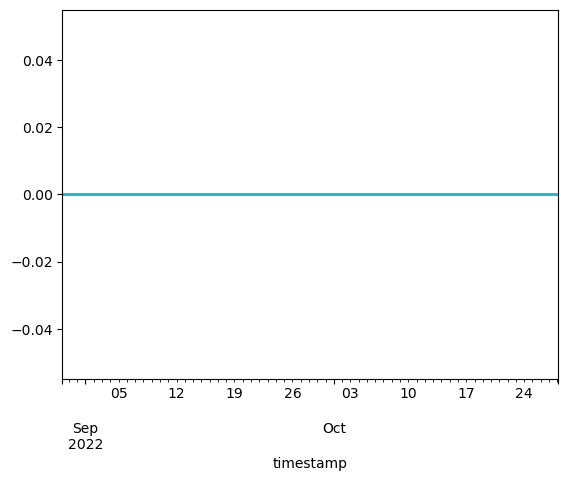

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


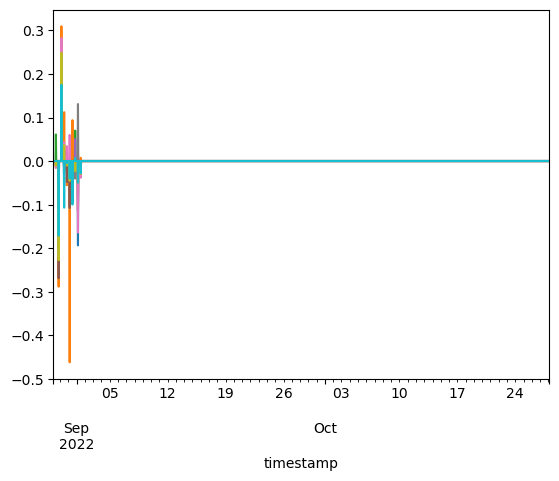

In [1]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221028_btc_one_cnn_h8.xz')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()